In [62]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from msc_project.utils import data_utils as du
from msc_project.utils import plot_utils as pu
import os
import pickle
import torch

plt.style.use('ggplot')

In [63]:
#DATA_DIR = '/scratch/msc24h18/msc_project/results/test25'
DATA_DIR = '/scratch/msc24h18/msc_project/tmp'
summary_files = du.get_summary_files(DATA_DIR)
weights_files = du.get_files(DATA_DIR, 'pkl', 'weights', 'analog')
analog_weights_files = du.get_files(DATA_DIR, 'pkl', 'analog_weights')
summaries = [du.read_summary_file(f)[0] for f in summary_files]
weights = [pickle.load(open(f, 'rb')) for f in weights_files]
analog_weights = [pickle.load(open(f, 'rb')) for f in analog_weights_files]
# first layer is split into two (256,392) layers, so combine them into one (256,784)
for w in weights:
    for w_i in w:
        t1 = w_i['0.analog_module.array.0.0'][0]
        t2 = w_i['0.analog_module.array.1.0'][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop('0.analog_module.array.0.0', None)
        w_i.pop('0.analog_module.array.1.0', None)
        w_i['0.analog_module'] = new_weight
        w_i.move_to_end('0.analog_module', last=False)


for w in analog_weights:
    for w_i in w:
        t1 = w_i[0][0]
        t2 = w_i[1][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop(0)
        w_i.pop(1)
        w_i.insert(0, new_weight)


In [64]:
def filter_data(summaries, weights, filter_col = 'device_id', filter_val = 'ID294YR'):
    filtered_summaries = []
    filtered_weights = []
    for s, w in zip(summaries, weights):
        if s[filter_col] == filter_val:
            filtered_summaries.append(s)
            filtered_weights.append(w)

    return filtered_summaries, filtered_weights

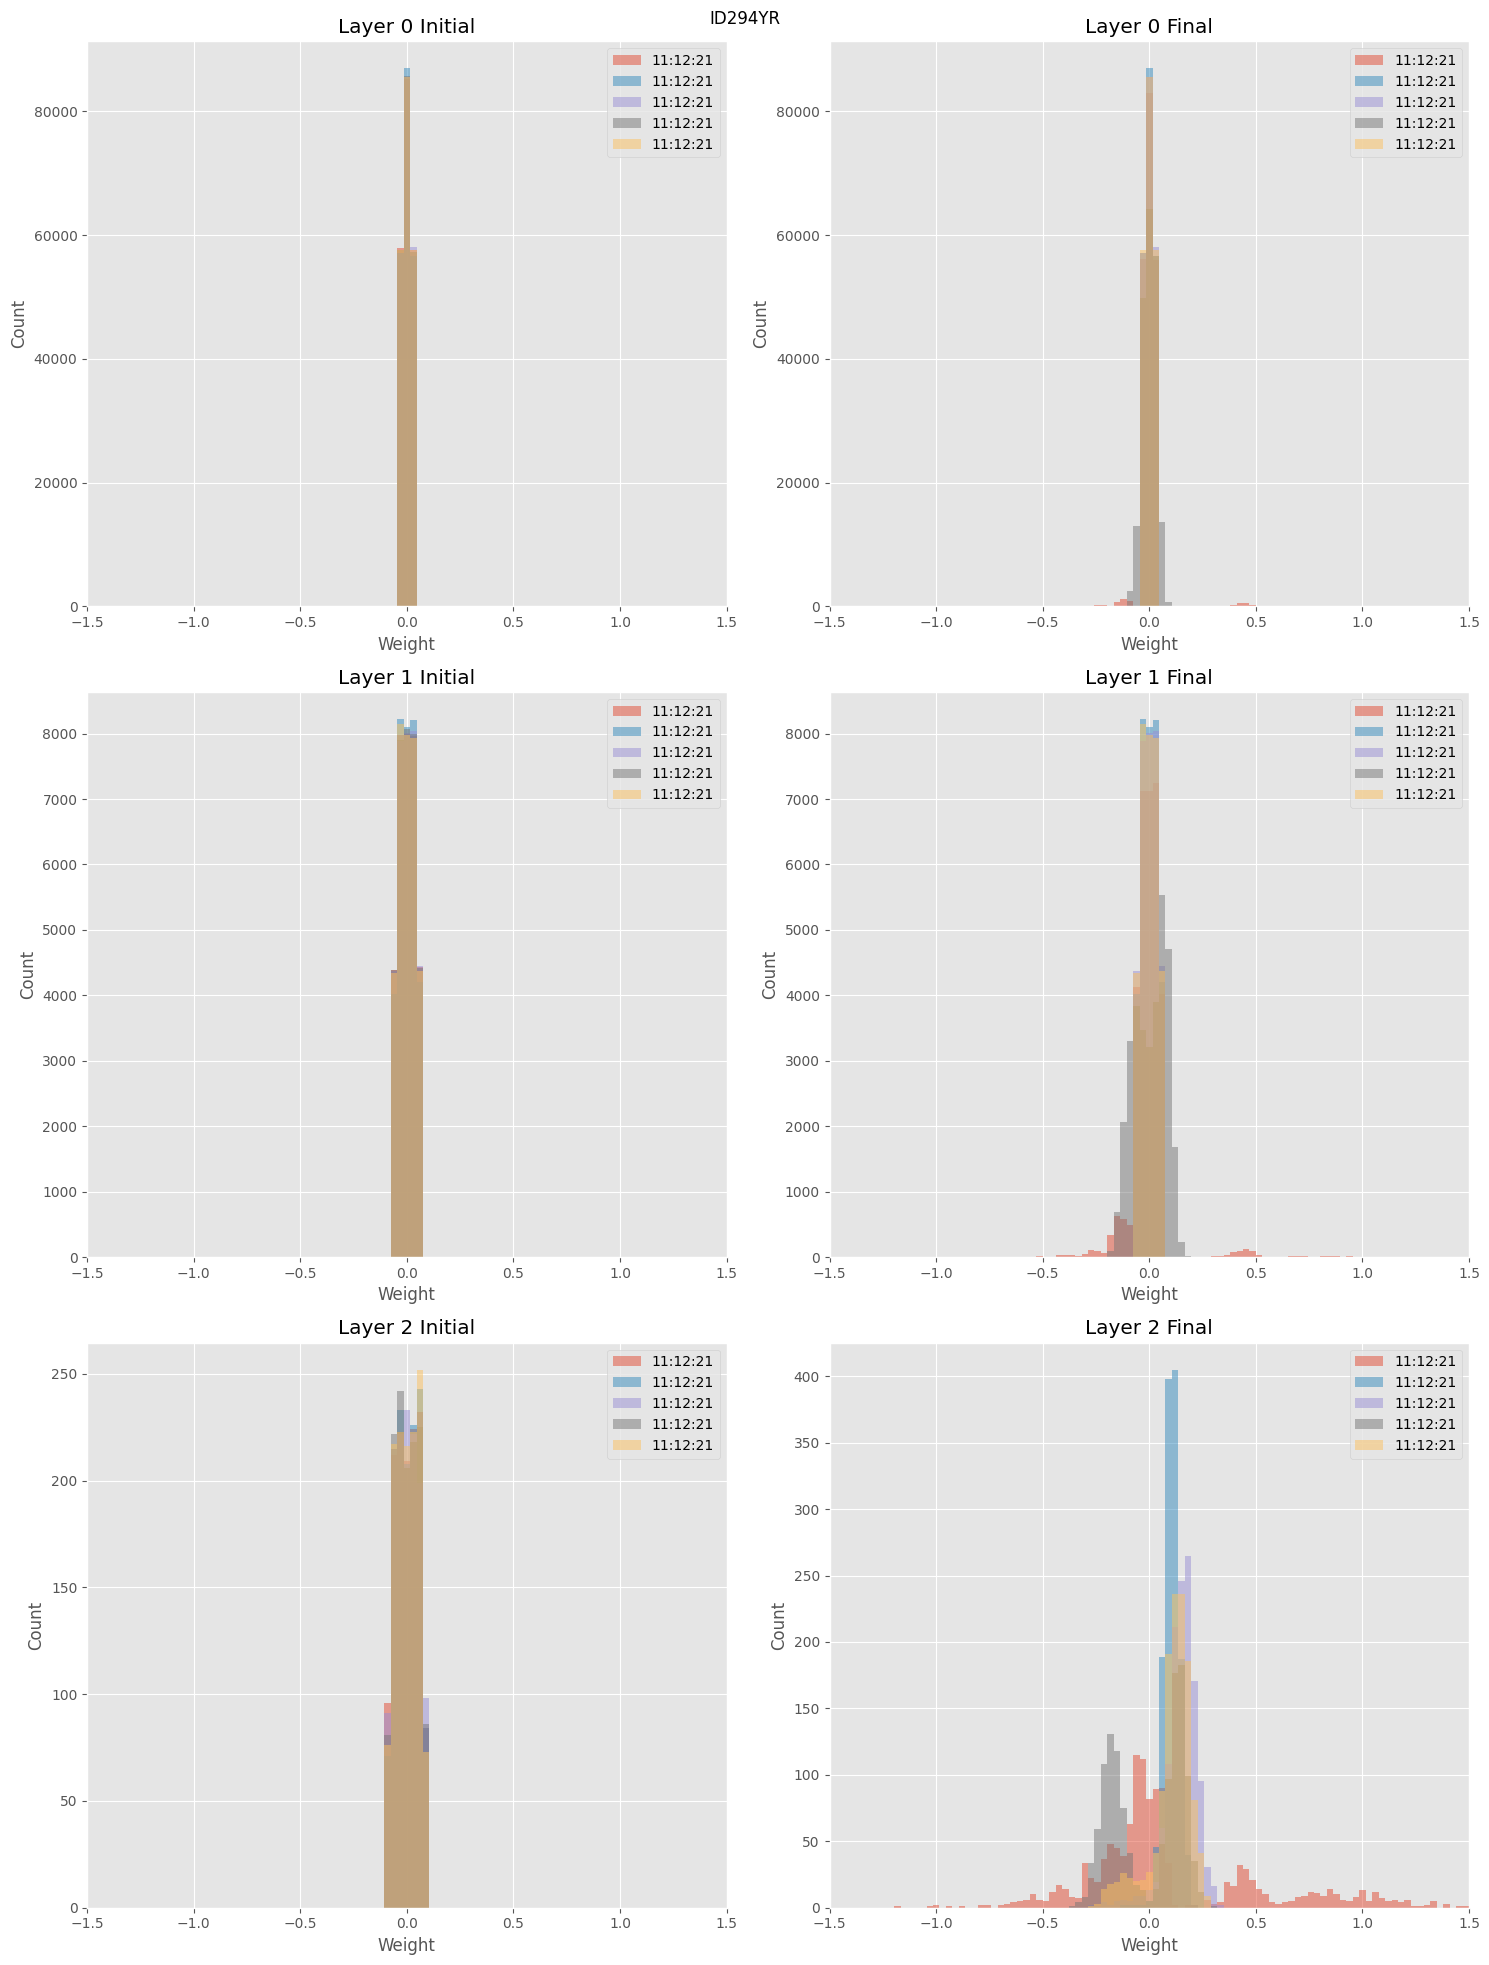

In [65]:
filter_col = "device_id"
filter_val = "ID294YR"
filtered_summaries, filtered_weights = filter_data(summaries, weights, filter_col=filter_col, filter_val=filter_val)
pu.plot_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle=filter_val)
#pu.animate_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')

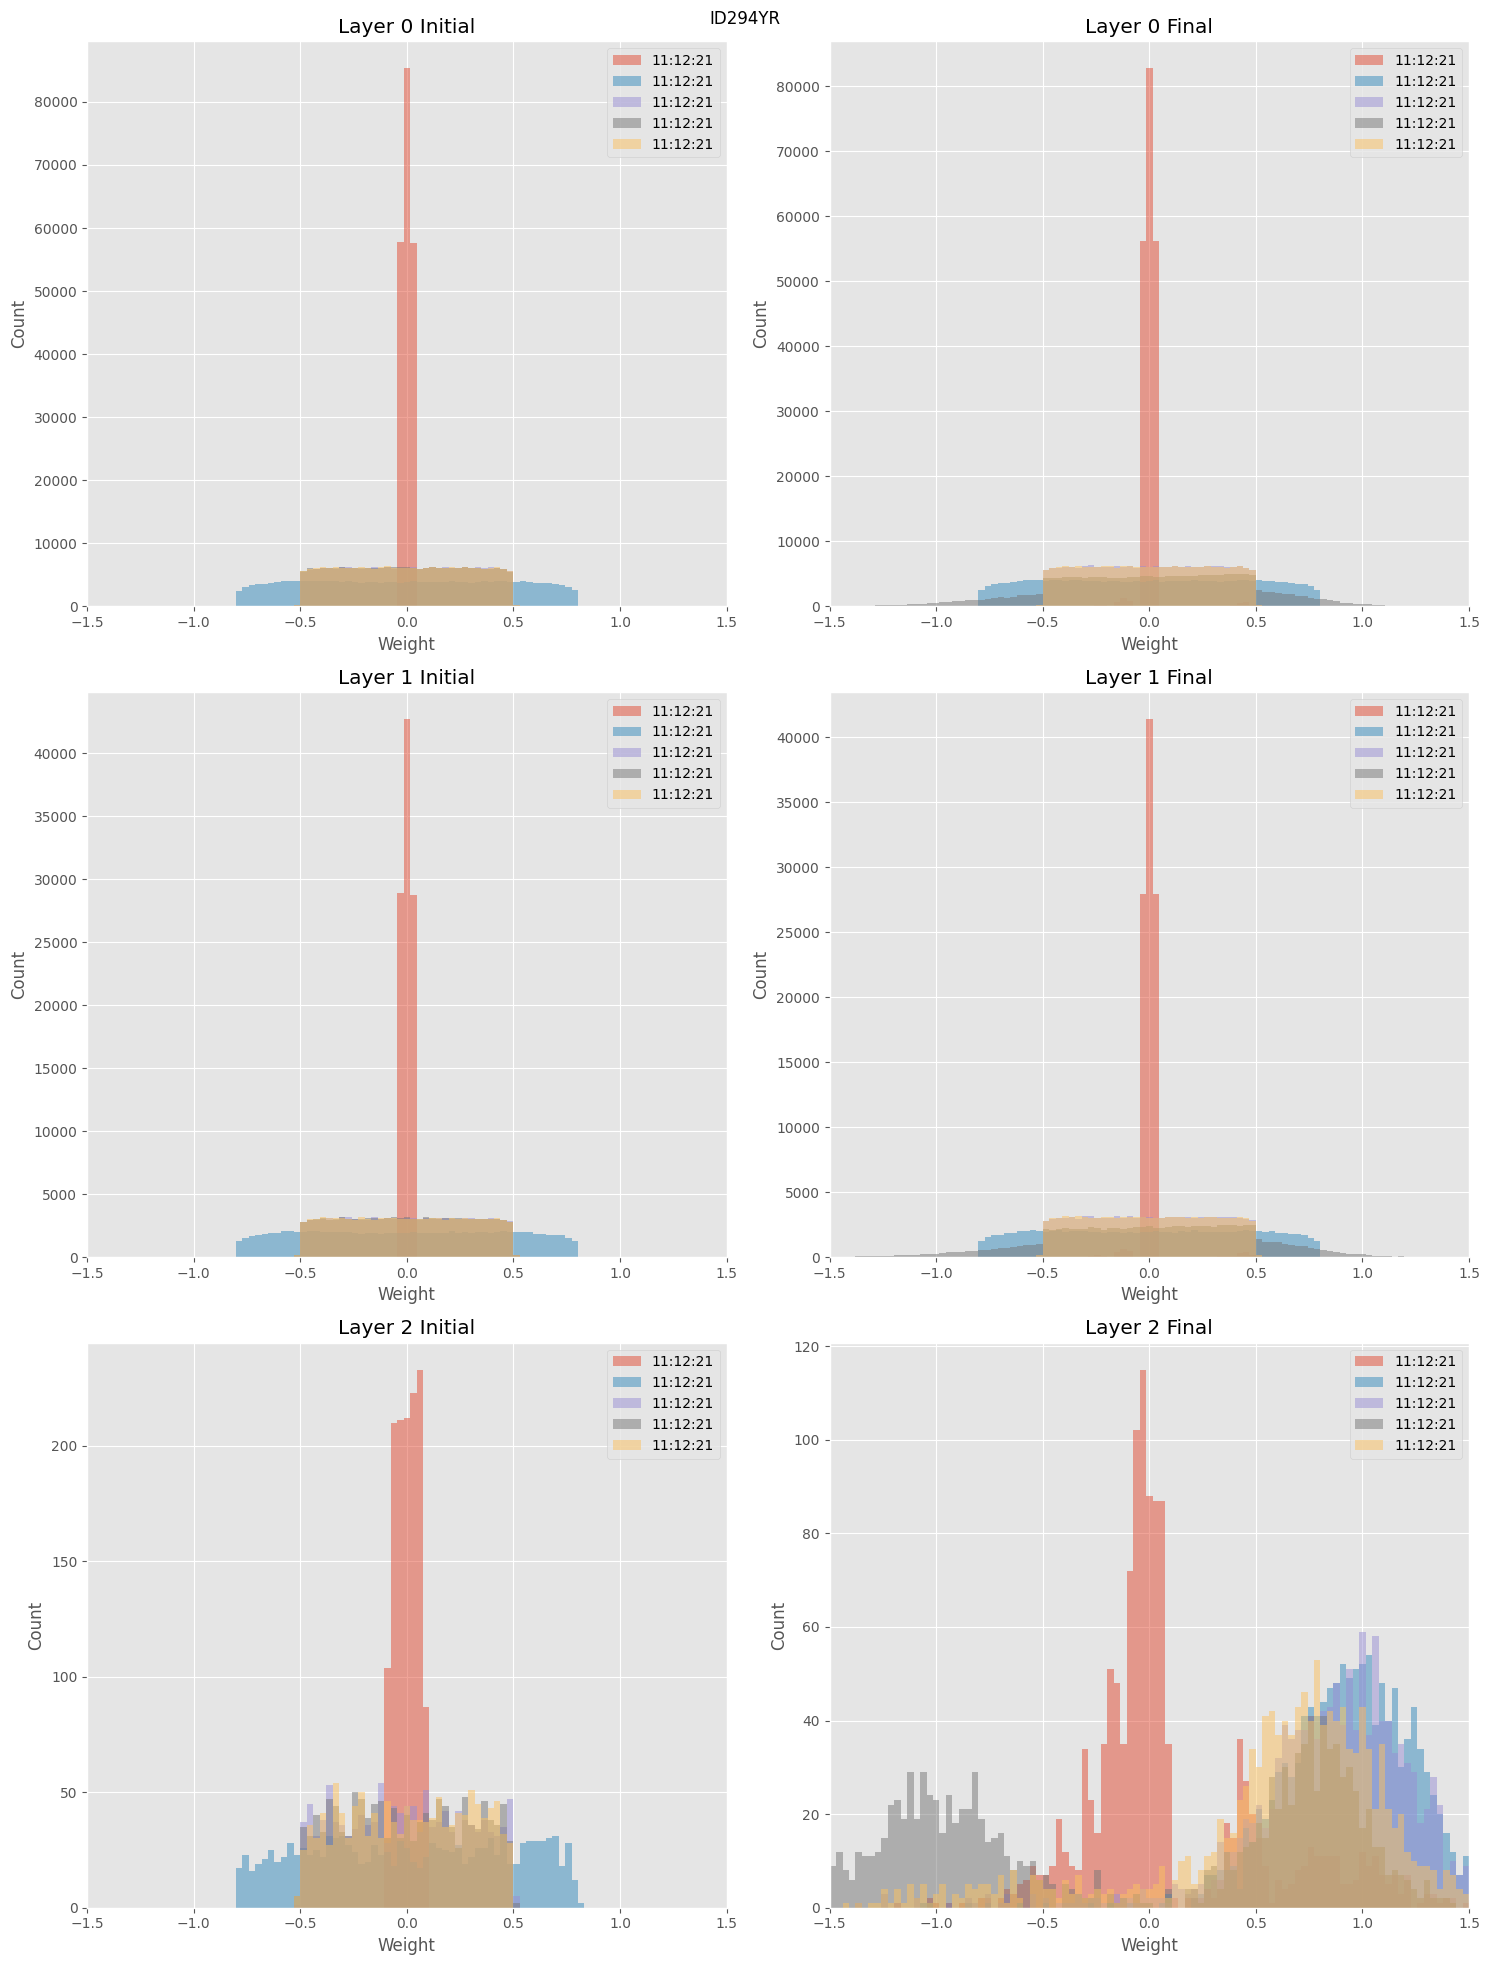

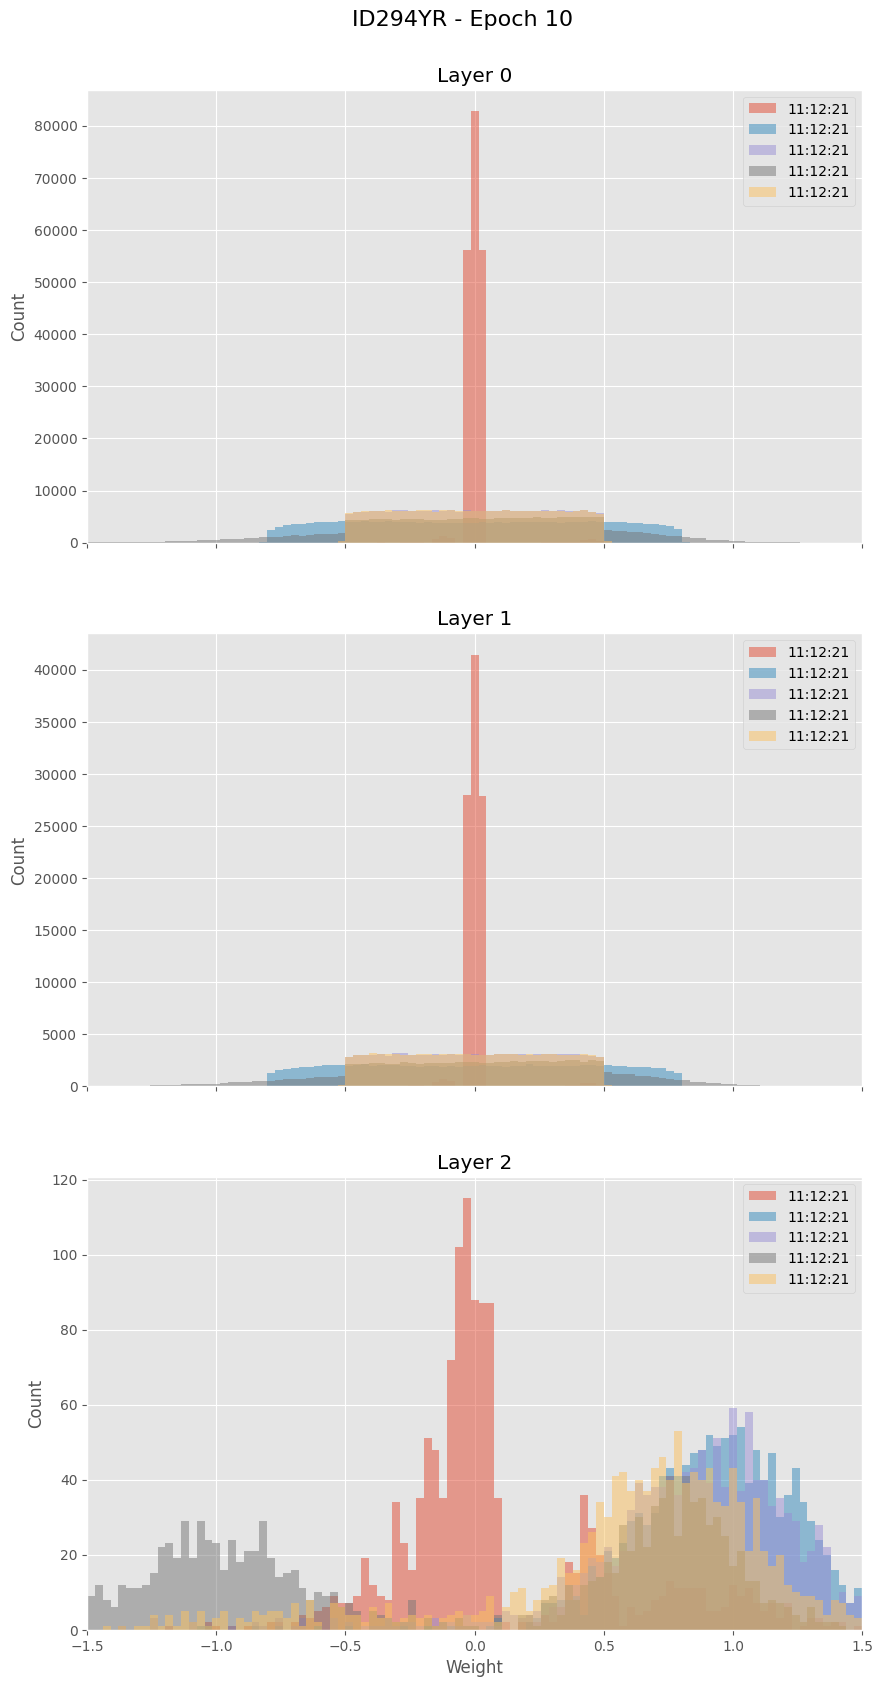

In [ ]:
filtered_summaries, filtered_weights = filter_data(summaries, analog_weights, filter_col=filter_col, filter_val=filter_val)
pu.plot_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')
#pu.animate_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')

In [67]:
filtered_summaries, filtered_weights = filter_data(summaries, weights, filter_col='device_id', filter_val='ID301XR1000Oct')

huekey = 'pulseWidth'
huevals = np.array([float(s[huekey]) for s in filtered_summaries])
cmap = mpl.colormaps['plasma']
norm = mpl.colors.LogNorm(huevals.min(), huevals.max())

pu.plot_weight_hist(filtered_weights, labels=[s[huekey] for s in filtered_summaries], suptitle='ID301XR1000Oct', huevals=huevals, cmap=cmap, norm=norm)
#pu.animate_weight_hist(filtered_weights, labels=[s['pulseWidth'] for s in filtered_summaries], suptitle='ID301XR1000Oct', huevals=huevals, cmap=cmap, norm=norm)

ValueError: zero-size array to reduction operation minimum which has no identity